# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this capstone project, we aim to provide valuable insight on local competitive landscape to those who want to establish new food outlet/eatery in New York city. Given the location data of various types of food outlets in New York city, we predict the dominant/common type of food outlets present in different parts of New York city which will be quite useful while in deciding about the location and type of new food outlet.

Mainly, the businessmen who are interested in setting up a new food outlet/eatery in New York city would be interested very interested to have the details of local competitive landscape as a input for their business strategy making. Besides, any already existing eatery owners also would be interested to have the details of this analysis as it would help them understand the geo-distribution of competitors in that locality in order to refine their business strategy.

## Data <a name="data"></a>

In this project, first, we obtain the data that contains the boroughs and the neighborhoods of the New York City. It also contains the latitude and longitude of each neighborhood of every borough in the city.  Later, using them, we obtain the data of food outlets/ eateries (along with their type) inside each Borough. 

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [23]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


The details of Boroughs and their neighborhoods of New York city along with their latitudes and longitudes are obtained from https://geo.nyu.edu/catalog/nyu_2451_34572 in a ‘.json’file. We load the ‘.json’ file and extract the ‘features’ data which has four columns ‘Borough’, ‘Neighborhood’, ‘Latitude’, ‘Longitude’. This data is later transformed into a Pandas dataframe.

<a id='item1'></a>

In [24]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [25]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [ ]:
newyork_data

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [27]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [28]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [29]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [30]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [31]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [32]:
neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [33]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [34]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [35]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

## Methodology <a name="methodology"></a>

 

In this section, we perform the exploratory data analysis on dataframe corresponding to each borough. Note that first we will perform the analysis on the data related to Manhattan borough and the same is applied later on the remaining four boroughs as well. In this section, we will perform predictive modeling of the data by using K-means clustering. In our problem, clustering helps to divide the neighborhoods of a given borough into clusters so that each neighborhood in a given cluster will have similarity in the types of food outlets with respect to the other neighborhoods within the same cluster as well as dissimilarity with respect to the neighborhoods present in the different cluster. With this, we can get to know the common/dominant type of food outlets in each cluster of a borough which is essentially the landscape of type of food outlets located inside a borough. 



#### We will repeat the following steps for every borough of NY City.  Fill the borough_label with name of the borough onto which analysis is to be performed 


## 1. Get the Neighborhood data of the Borough

In [36]:
borough_label = 'Manhattan'
borough_data = neighborhoods[neighborhoods['Borough'] == borough_label ].reset_index(drop=True)



Let's get the geographical coordinates of Borough.

In [37]:
address = borough_label

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Borough are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Borough are 40.7896239, -73.9598939.


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [38]:
CLIENT_ID = 'UM4NTMFYN2G5YFHWER4HJOF2K0XWOLUS3D5WWAT5IUDCWJVY' # your Foursquare ID
CLIENT_SECRET = 'CGEV55C4FUQNJO5JNQR53QYCU1EYLXDY5IBOIUBG3LBZAYHY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UM4NTMFYN2G5YFHWER4HJOF2K0XWOLUS3D5WWAT5IUDCWJVY
CLIENT_SECRET:CGEV55C4FUQNJO5JNQR53QYCU1EYLXDY5IBOIUBG3LBZAYHY


<a id='item2'></a>

## 2. Explore Neighborhoods of the Borough

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        CategoryId,
        LIMIT)
        url 
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### The code to run the above function on each neighborhood of the borough and create a new dataframe called *borough_venues*. (Note :  Venue represents food outlet/eatery and Venue category represents the type of food outlet/eatery

In [40]:
# type your answer here
LIMIT  = 25
radius = 500
CategoryId= '4d4b7105d754a06374d81259'

borough_venues = getNearbyVenues(names=borough_data['Neighborhood'],
                                   latitudes=borough_data['Latitude'],
                                   longitudes=borough_data['Longitude']
                                  )



#### Let's check the size of the resulting dataframe

In [41]:
print(borough_venues.shape)
borough_venues.shape

(957, 7)


(957, 7)

#### Let's find out how many unique categories can be curated from all the returned venues

In [42]:
print('There are {} uniques categories.'.format(len(borough_venues['Venue Category'].unique())))

There are 90 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [43]:
# one hot encoding
borough_onehot = pd.get_dummies(borough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
borough_onehot['Neighborhood'] = borough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [borough_onehot.columns[-1]] + list(borough_onehot.columns[:-1])
borough_onehot = borough_onehot[fixed_columns]



And let's examine the new dataframe size.

In [44]:
borough_onehot.shape

(957, 91)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [45]:
borough_grouped = borough_onehot.groupby('Neighborhood').mean().reset_index()
borough_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Battery Park City,0.0,0.00,0.04,0.0,0.00,0.0,0.0,0.04,0.00,0.00,0.04,0.00,0.08,0.0,0.00,0.04,0.0,0.00,0.0,0.08,0.0,0.0,0.00,0.0,0.00,0.04,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.08,0.08,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.04,0.04,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.16,0.0,0.00,0.00,0.0,0.04,0.12,0.0,0.04,0.00,0.0,0.00,0.00,0.04,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
1,Carnegie Hill,0.0,0.00,0.04,0.0,0.00,0.0,0.0,0.00,0.04,0.08,0.00,0.04,0.00,0.0,0.00,0.16,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.04,0.08,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.12,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.00,0.04,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.12,0.0,0.04,0.04,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.04,0.0,0.0,0.04,0.00,0.00,0.0,0.0,0.00,0.04,0.0
2,Central Harlem,0.0,0.12,0.08,0.0,0.00,0.0,0.0,0.00,0.04,0.00,0.00,0.00,0.04,0.0,0.04,0.04,0.0,0.04,0.0,0.08,0.0,0.0,0.04,0.0,0.00,0.00,0.0,0.00,0.04,0.0,0.0,0.0,0.0,0.00,0.00,0.08,0.12,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.04,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.08,0.00,0.0,0.04,0.00,0.00,0.00,0.0,0.0,0.00,0.04,0.00,0.0,0.0,0.04,0.00,0.0
3,Chelsea,0.0,0.00,0.12,0.0,0.04,0.0,0.0,0.00,0.00,0.08,0.00,0.00,0.04,0.0,0.00,0.00,0.0,0.00,0.0,0.04,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.04,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.04,0.0,0.04,0.08,0.0,0.08,0.0,0.0,0.0,0.00,0.0,0.00,0.04,0.00,0.04,0.0,0.0,0.04,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.04,0.0,0.12,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.04,0.04,0.00,0.0,0.0,0.04,0.00,0.0
4,Chinatown,0.0,0.00,0.08,0.0,0.08,0.0,0.0,0.00,0.00,0.04,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.12,0.0,0.0,0.00,0.0,0.04,0.00,0.0,0.04,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.08,0.0,0.0,0.08,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.08,0.00,0.00,0.00,0.0,0.0,0.04,0.08,0.0,0.0,0.0,0.04,0.0,0.00,0.00,0.0,0.00,0.08,0.0,0.00,0.04,0.0,0.00,0.04,0.00,0.00,0.0,0.0,0.00,0.00,0.04,0.0,0.0,0.00,0.00,0.0


#### Let's confirm the new size

In [46]:
borough_grouped.shape

(40, 91)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = borough_grouped['Neighborhood']

for ind in np.arange(borough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(borough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Pizza Place,Sandwich Place,Food Truck,Chinese Restaurant,Food Court,Burger Joint,BBQ Joint,Donut Shop,Steakhouse,Bistro
1,Carnegie Hill,Café,Pizza Place,Italian Restaurant,French Restaurant,Bakery,Bagel Shop,Mediterranean Restaurant,Ramen Restaurant,Restaurant,Kosher Restaurant
2,Central Harlem,African Restaurant,Fried Chicken Joint,French Restaurant,Chinese Restaurant,American Restaurant,Seafood Restaurant,Cafeteria,Caribbean Restaurant,Burger Joint,Pizza Place
3,Chelsea,American Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Bakery,Chinese Restaurant,Israeli Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Sandwich Place
4,Chinatown,Chinese Restaurant,Hotpot Restaurant,American Restaurant,Noodle House,Asian Restaurant,Greek Restaurant,Malay Restaurant,Sandwich Place,Pizza Place,Spanish Restaurant


In [49]:
neighborhoods_venues_sorted.shape

(40, 11)

<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means for different values of to findout the optimum value of k

(array([1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 8 Text xticklabel objects>)

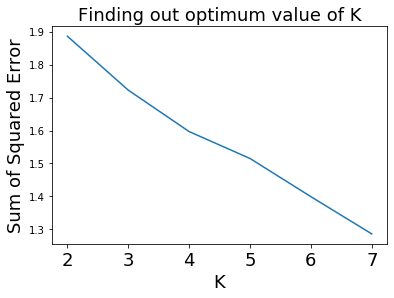

In [53]:
# set number of clusters
borough_grouped_clustering = borough_grouped.drop('Neighborhood', 1)
import matplotlib.pyplot as plt2
Kmax =7
def calculate_WSS(points, kmax):
  sse = []
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    sse.append(kmeans.inertia_)
  return sse
sse_data = calculate_WSS(borough_grouped_clustering, Kmax)
plt2.plot(range(2,Kmax+1),sse_data)
plt2.title('Finding out optimum value of K', fontsize=18)
plt2.ylabel('Sum of Squared Error', fontsize=18)
plt2.xlabel('K', fontsize=18)
plt2.xticks(fontsize=18)

Perform K-means clustering for the optimum value of k obtained Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood  

In [54]:
kclusters = 4
kmeans = KMeans(n_clusters = kclusters).fit(borough_grouped_clustering)
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

borough_merged = borough_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
borough_merged = borough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

borough_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Sandwich Place,Deli / Bodega,American Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Asian Restaurant,Diner,Donut Shop,Steakhouse
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Hotpot Restaurant,American Restaurant,Noodle House,Asian Restaurant,Greek Restaurant,Malay Restaurant,Sandwich Place,Pizza Place,Spanish Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Deli / Bodega,New American Restaurant,Chinese Restaurant,Tapas Restaurant,Café,Bakery,Breakfast Spot,Latin American Restaurant,Pizza Place,Caribbean Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Restaurant,Café,Deli / Bodega,Spanish Restaurant,Chinese Restaurant,American Restaurant,Bakery,Latin American Restaurant,Seafood Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Café,Mexican Restaurant,Caribbean Restaurant,Pizza Place,Bakery,Burger Joint,Sushi Restaurant,Latin American Restaurant,Seafood Restaurant,Mediterranean Restaurant


## Results and Discussion <a name="results"></a>

Finally, let's visualize the resulting clusters

In [55]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(borough_merged['Latitude'], borough_merged['Longitude'], borough_merged['Neighborhood'], borough_merged['Cluster Labels']):
    #cluster = int(cluster1)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

 Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1

Hello


Text(0.5, 0, 'Type of food outlet')

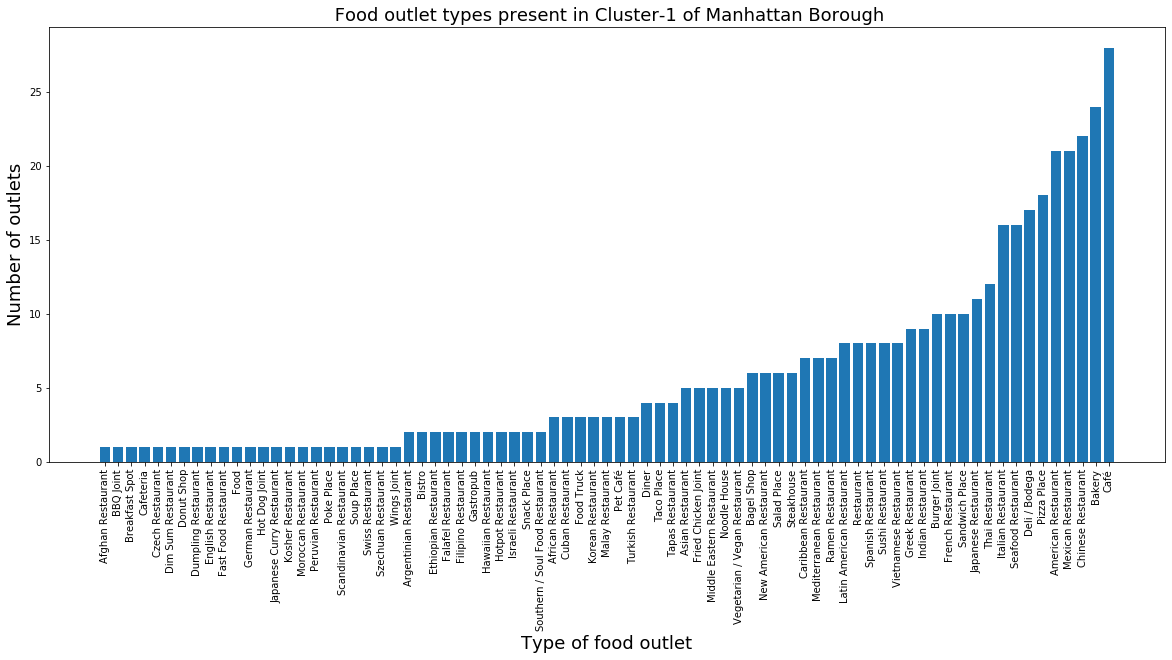

In [57]:
df_test = borough_merged.loc[borough_merged['Cluster Labels'] == 0, borough_merged.columns[[1] + list(range(5, borough_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = borough_onehot.loc[borough_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-1 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)

We can observe that Italian Restaurant, American Restaurant, French Restaurant, Sushi restaurant, Café are the top 5 common/dominant types of food outlets present in Cluster-1 of Manhattan. This suggests that any new food outlet to be launched in Cluster-1 make sure that type of food offered is different to those 5 types of food outlets in order to draw more customers. It also suggests that Cluster-1 of Manhattan is not the ideal place to open a new Italian, American, Sushi, or French food outlets or a Cafe. 

Findout the Neighborhoods present inside Cluster-1

In [58]:
df_test['Neighborhood']

1              Chinatown
2     Washington Heights
3                 Inwood
4       Hamilton Heights
5         Manhattanville
6         Central Harlem
7            East Harlem
10            Lenox Hill
11      Roosevelt Island
12       Upper West Side
15               Midtown
17               Chelsea
19          East Village
20       Lower East Side
21               Tribeca
22          Little Italy
25      Manhattan Valley
36            Tudor City
37       Stuyvesant Town
Name: Neighborhood, dtype: object

#### Cluster 2

Hello


Text(0.5, 0, 'Type of food outlet')

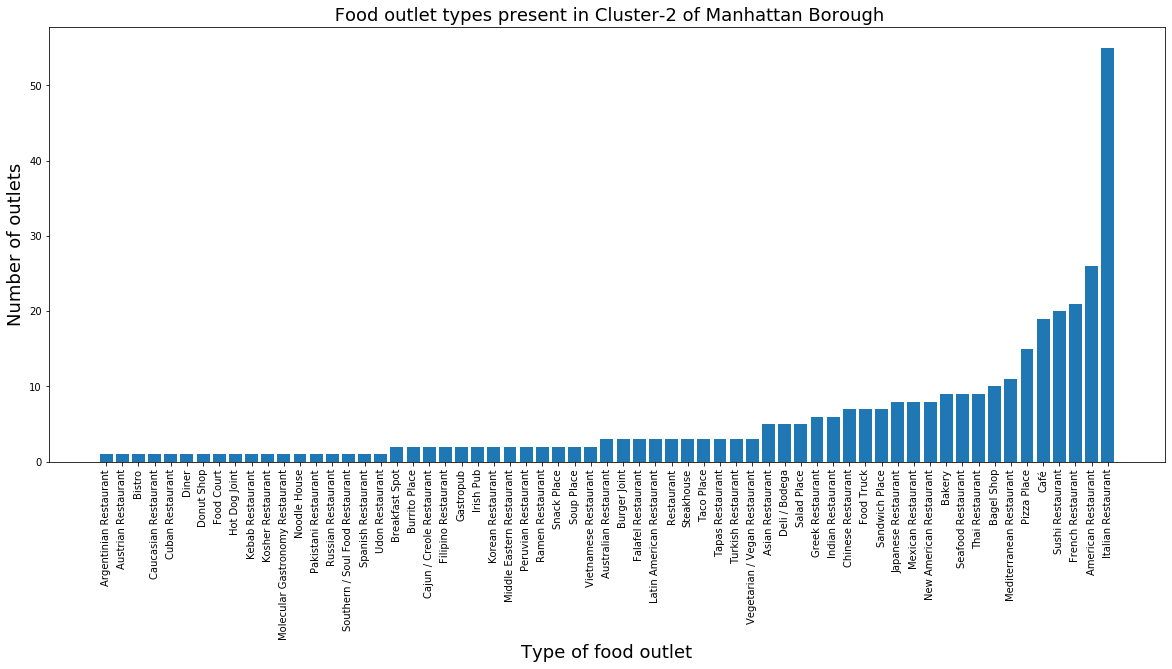

In [59]:
df_test = borough_merged.loc[borough_merged['Cluster Labels'] == 1, borough_merged.columns[[1] + list(range(5, borough_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = borough_onehot.loc[borough_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-2 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)

Findout the Neighborhoods present inside Cluster-2

In [60]:
df_test['Neighborhood']

8       Upper East Side
9             Yorkville
13       Lincoln Square
18    Greenwich Village
23                 Soho
24         West Village
27             Gramercy
30        Carnegie Hill
31                 Noho
32         Civic Center
34         Sutton Place
35           Turtle Bay
38             Flatiron
39         Hudson Yards
Name: Neighborhood, dtype: object

#### Cluster 3

Hello


Text(0.5, 0, 'Type of food outlet')

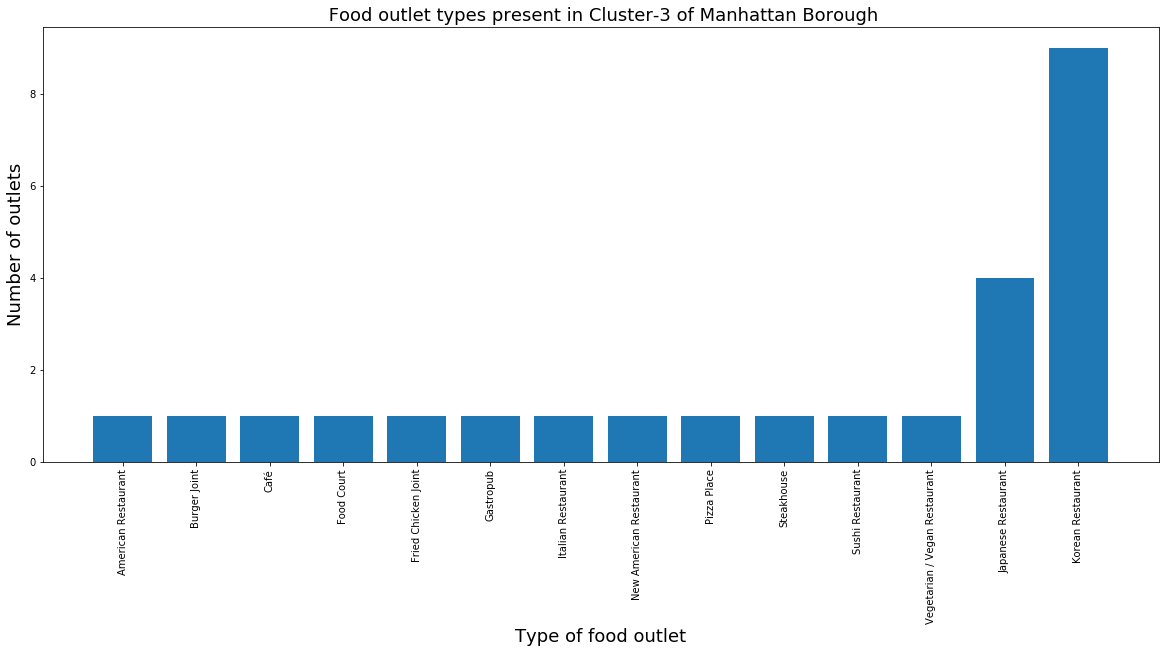

In [62]:
df_test = borough_merged.loc[borough_merged['Cluster Labels'] == 2, borough_merged.columns[[1] + list(range(5, borough_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = borough_onehot.loc[borough_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-3 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)


Findout the Neighborhoods present inside Cluster-3

In [63]:
df_test['Neighborhood']

33    Midtown South
Name: Neighborhood, dtype: object

#### Cluster 4

Hello


Text(0.5, 0, 'Type of food outlet')

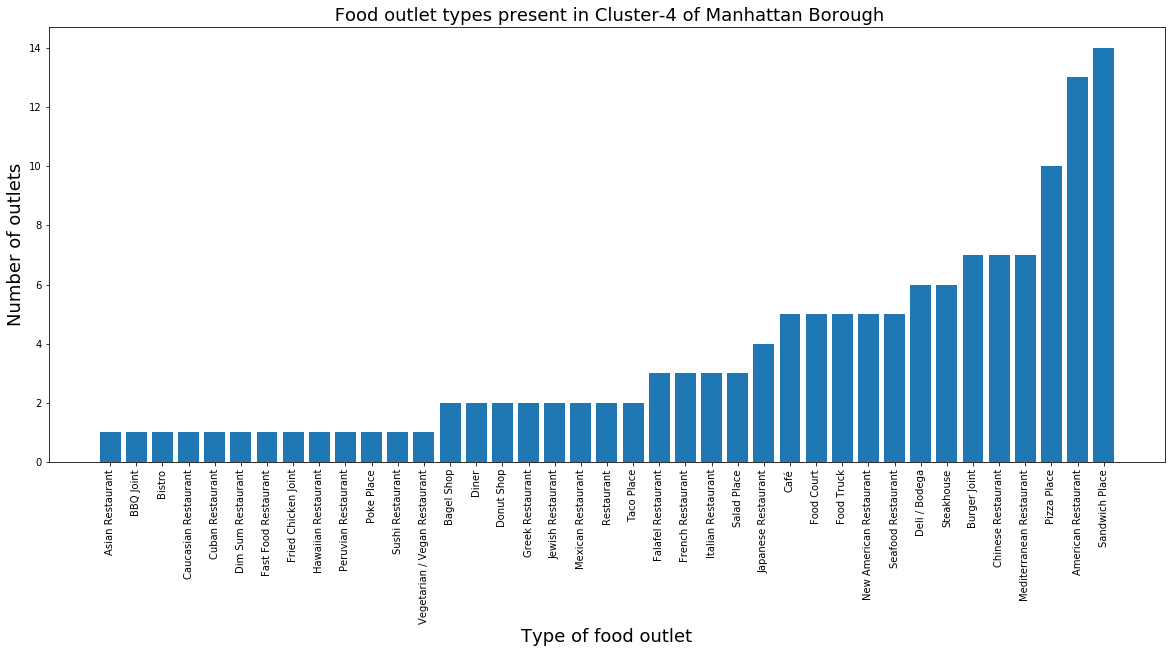

In [64]:
df_test = borough_merged.loc[borough_merged['Cluster Labels'] == 3, borough_merged.columns[[1] + list(range(5, borough_merged.shape[1]))]]
df_test.reset_index(drop=True)
list_neighbor = df_test['Neighborhood'].to_list()
df_data_3 = borough_onehot.loc[borough_onehot['Neighborhood'].isin(list_neighbor)]
df_data_3
dict_items = {}
for column in df_data_3:
    if column =='Neighborhood':
        print('Hello')
    else:
        col_ser = df_data_3[column]
        val_data = col_ser.sum()
        dict_items.update({column:val_data})
dict_items_ref = {key:val for key, val in dict_items.items() if val !=0 }
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
list_items_ref_sorted = sorted(dict_items_ref.items(), key = lambda x: x[1])
keys_data, value_data = zip(*list_items_ref_sorted)
# keys_data = dict_items_ref_sorted.keys()
# value_data = dict_items_ref_sorted.values()
plt.bar(keys_data, value_data)
plt.xticks(rotation=90)
plt.title(' Food outlet types present in Cluster-4 of Manhattan Borough', fontsize=18)
plt.ylabel('Number of outlets',fontsize=18)
plt.xlabel('Type of food outlet', fontsize=18)

Findout the Neighborhoods present inside Cluster-4

In [65]:
df_test['Neighborhood']

0             Marble Hill
14                Clinton
16            Murray Hill
26    Morningside Heights
28      Battery Park City
29     Financial District
Name: Neighborhood, dtype: object

The same process is repeated for the remaining four boroughs Bronx, Queens, Brooklyn, and Staten Island

## Conclusion <a name="conclusion"></a>

In this project, we predicted the dominant/common type of food outlets present in different parts of New York city with help of location data of various types of food outlets in New York city. Using the latitudes and longitudes of neighborhoods in NY city, we obtained the location data of different types of food outlets with the help of Foursquare API.  

Neighborhoods of each borough in NY city has been partitioned into different clusters using K-means clustering algorithm by taking top 10 common food outlets of each neighborhood as a data sample. This analysis can be helpful for those businessmen who are planning to open a new food outlet in NY city. It can help them in deciding the type of food outlet that provides them the competitive advantage
